### Sección 1: Importación de librerías y carga de datos

En esta sección importamos las bibliotecas necesarias para el análisis. Usamos `fetch_ucirepo` para obtener el dataset del UCI Machine Learning Repository, específicamente el dataset de rendimiento académico de estudiantes. Convertimos las variables categóricas en variables dummy utilizando `pd.get_dummies()`.


In [224]:
import numpy as np
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

student_performance = fetch_ucirepo(id=320)

X = student_performance.data.features
y = student_performance.data.targets

In [225]:
df = pd.concat([X,y],axis=1)
X_dummies = pd.get_dummies(df, drop_first=True)
X_dummies

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,0,4,3,2,2,...,True,False,True,False,False,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,False,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,19,2,3,1,3,1,5,4,2,1,...,True,False,False,False,False,True,False,True,True,False
645,18,3,1,1,2,0,4,3,4,1,...,True,False,False,True,False,False,True,True,True,False
646,18,1,1,2,2,0,1,1,1,1,...,True,False,False,False,False,True,True,True,False,False
647,17,3,1,2,1,0,2,4,5,3,...,True,False,False,False,False,False,False,True,True,False


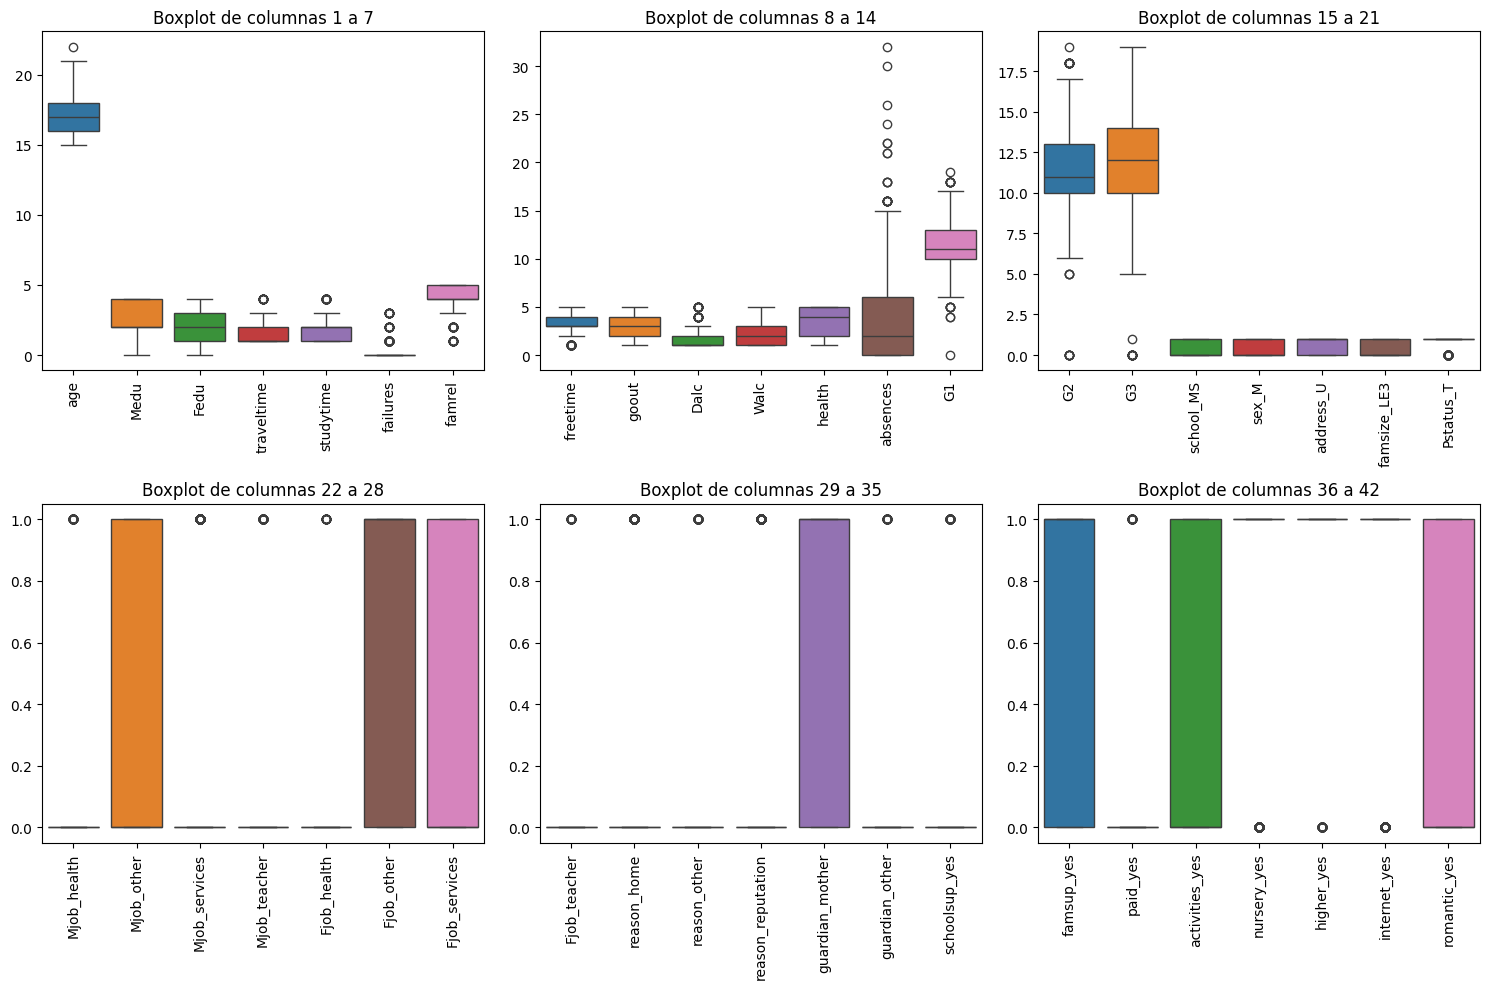

In [226]:
column_groups = [X_dummies.columns[i:i+7] for i in range(0, len(X_dummies.columns), 7)]

plt.figure(figsize=(15, 10))

for i, group in enumerate(column_groups):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=X_dummies[group])
    plt.title(f'Boxplot de columnas {i*7+1} a {i*7+7}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [227]:
percentil_95 = X_dummies['absences'].quantile(0.95)

X_final_filtered = X_dummies[X_dummies['absences'] <= percentil_95]

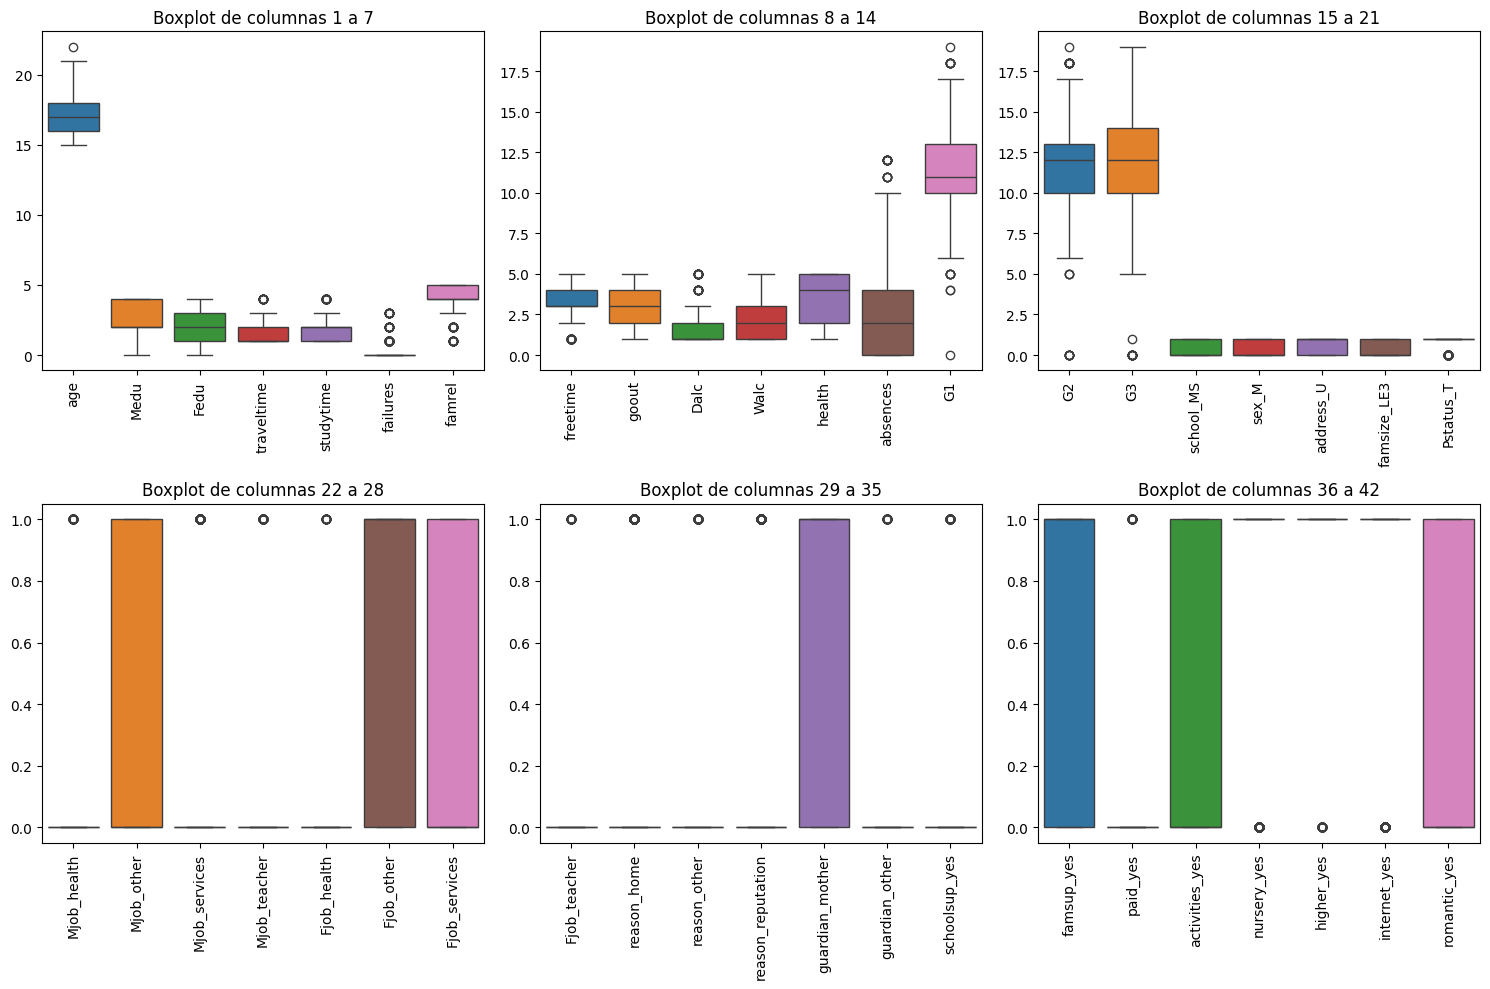

In [228]:
column_groups = [X_final_filtered.columns[i:i+7] for i in range(0, len(X_final_filtered.columns), 7)]

plt.figure(figsize=(15, 10))

for i, group in enumerate(column_groups):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=X_final_filtered[group])
    plt.title(f'Boxplot de columnas {i*7+1} a {i*7+7}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Las columnas fueron seleccionadas a partir de un código llamado **"prueba.ipynb"**, en el cual se busca automáticamente la combinación de columnas que proporciona el mejor rendimiento entre todas las combinaciones posibles.

- **Recomendación**: No es recomendable ejecutarlo, ya que tarda al menos 11 minutos (dependiendo del equipo y código).


In [229]:

final_columns = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'freetime', 'goout', 'Dalc', 'health', 
                 'absences', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 
                 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 
                 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 
                 'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 
                 'higher_yes', 'internet_yes', 'romantic_yes']

X_final = X_final_filtered[final_columns]
G1 = X_final_filtered['G1']
G2 = X_final_filtered['G2']
G3 = X_final_filtered['G3']



### Sección 2: División del conjunto de datos y selección de características

Aquí dividimos el conjunto de datos en subconjuntos de entrenamiento y prueba utilizando `train_test_split`. Además, seleccionamos manualmente algunas características relevantes para reducir la carga computacional al evitar todas las combinaciones posibles.


In [230]:
results = []

def evaluar_modelos(X_train, X_test, y_train, y_test, target_name):
    modelos = {
        "Linear Regression": LinearRegression(),
        "Lasso Regression": Lasso(alpha=0.1),
        "Random Forest": RandomForestRegressor(random_state=42)
    }

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Modelo: {nombre} - {target_name}")
        print(f"R²: {r2:.4f}")
        print("-------")

### Sección 3: Entrenamiento y evaluación de modelos

En esta sección entrenamos tres modelos: **Lasso**, **Random Forest**, y **Regresión Lineal**. Después de entrenar los modelos, calculamos el coeficiente de determinación \( R^2 \), que mide qué tan bien se ajusta el modelo a los datos de prueba.


In [231]:



for g, target in zip(['G1', 'G2', 'G3'], [G1, G2, G3]):
    X_train, X_test, y_train, y_test = train_test_split(X_final, target, test_size=0.3, random_state=42)
    
    print(f"Evaluando para {g}")
    evaluar_modelos(X_train, X_test, y_train, y_test, g)
    print("\n")

Evaluando para G1
Modelo: Linear Regression - G1
R²: 0.2144
-------
Modelo: Lasso Regression - G1
R²: 0.2540
-------
Modelo: Random Forest - G1
R²: 0.2510
-------


Evaluando para G2
Modelo: Linear Regression - G2
R²: 0.1960
-------
Modelo: Lasso Regression - G2
R²: 0.1942
-------
Modelo: Random Forest - G2
R²: 0.2530
-------


Evaluando para G3
Modelo: Linear Regression - G3
R²: 0.2637
-------
Modelo: Lasso Regression - G3
R²: 0.2519
-------
Modelo: Random Forest - G3
R²: 0.3203
-------




### Clasificador: predicción de si un estudiante pasa o pierde basado en la suma de G1, G2, G3
Agregar una columna que sume G1, G2, y G3

In [232]:
X_final_filtered['total_puntos'] = G1 + G2 + G3
X_final_filtered['pasa_pierde'] = (X_final_filtered['total_puntos'] > 50).astype(int)

C:\Users\juano\AppData\Local\Temp\ipykernel_7964\3801429481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final_filtered['total_puntos'] = G1 + G2 + G3
C:\Users\juano\AppData\Local\Temp\ipykernel_7964\3801429481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final_filtered['pasa_pierde'] = (X_final_filtered['total_puntos'] > 50).astype(int)


In [233]:
columnas_a_excluir = ['G1', 'G2', 'G3', 'pasa_pierde']
df_sin_resultado= X_final_filtered.drop(columns=columnas_a_excluir)

In [234]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(df_sin_resultado, X_final_filtered['pasa_pierde'], test_size=0.3, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_class, y_train_class)

# Realizar predicciones
y_pred_class = clf.predict(X_test_class)

# Calcular precisión del clasificador
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Precisión del clasificador (Pasa/Pierde): {accuracy:.4f}")

Precisión del clasificador (Pasa/Pierde): 0.9731
